In [1]:
import pandas as pd
from scipy import stats
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from datetime import datetime
import random

import sys

from dateutil.parser import parse
from matplotlib import dates

from sklearn import preprocessing, neighbors, linear_model, model_selection, ensemble

In [2]:
d = pd.read_csv('../data/2016_subset_all_tables.csv', index_col = 0)

In [3]:
d.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,transactions,holitype
id,,,,,,,,,,,,,,,
71278985,2016-02-22,6,1464027,3.0,False,BEVERAGES,1148,0,31.37,Quito,Pichincha,D,13,1630,No_Holiday
82077989,2016-06-14,6,1913600,1.0,False,PERSONAL CARE,4118,0,48.49,Quito,Pichincha,D,13,1603,No_Holiday
92852321,2016-10-04,6,881701,2.0,False,GROCERY I,1042,0,48.67,Quito,Pichincha,D,13,1605,No_Holiday
72713582,2016-03-08,6,1150954,2.0,False,BEVERAGES,1124,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday
72714342,2016-03-08,6,1898960,5.0,False,BEVERAGES,1126,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday


In [4]:
d['date_as_datetime'] = [parse(x) for x in d['date']]
d['date_as_num'] = [dates.date2num(x) for x in d['date_as_datetime']]

In [5]:
d.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,transactions,holitype,date_as_datetime,date_as_num
id,,,,,,,,,,,,,,,,,
71278985,2016-02-22,6,1464027,3.0,False,BEVERAGES,1148,0,31.37,Quito,Pichincha,D,13,1630,No_Holiday,2016-02-22,736016.0
82077989,2016-06-14,6,1913600,1.0,False,PERSONAL CARE,4118,0,48.49,Quito,Pichincha,D,13,1603,No_Holiday,2016-06-14,736129.0
92852321,2016-10-04,6,881701,2.0,False,GROCERY I,1042,0,48.67,Quito,Pichincha,D,13,1605,No_Holiday,2016-10-04,736241.0
72713582,2016-03-08,6,1150954,2.0,False,BEVERAGES,1124,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday,2016-03-08,736031.0
72714342,2016-03-08,6,1898960,5.0,False,BEVERAGES,1126,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday,2016-03-08,736031.0


In [6]:
d = d.join(pd.get_dummies(d['family'], prefix = 'family'))
d = d.join(pd.get_dummies(d['type'], prefix = 'type'))
d = d.join(pd.get_dummies(d['city'], prefix = 'city'))
d = d.join(pd.get_dummies(d['holitype'], prefix = 'holitype'))

In [7]:
d = d.dropna()

In [8]:
v_train, v_test = model_selection.train_test_split(d, test_size = 0.25)

In [9]:
v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
       'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])

print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
all_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0193525542646


In [10]:
knn = neighbors.KNeighborsRegressor()

knn_param_grid = [
    {'n_neighbors': range(1,200, 10)}
]

knn_grid = model_selection.GridSearchCV(knn, param_grid = knn_param_grid)
knn_grid.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(knn_grid.cv_results_['split0_test_score'])
print(knn_grid.cv_results_['split1_test_score'])
print(knn_grid.cv_results_['split2_test_score'])

[ -5.03607300e+00  -2.61919148e-01  -1.11480905e-01  -9.01500153e-02
  -8.42049423e-02  -8.15895341e-02  -8.22680871e-02  -6.76898385e-02
  -5.37514048e-02  -4.46060663e-02  -3.72303270e-02  -2.81538868e-02
  -2.10706539e-02  -1.57531240e-02  -1.03868858e-02  -7.86202634e-03
  -5.65824978e-03  -3.75478023e-03  -2.01951066e-03  -1.59659763e-03]
[ -1.26555922e+00  -2.22749620e-01  -1.52372847e-01  -9.32815564e-02
  -6.13209439e-02  -3.68999261e-02  -1.83187061e-02  -9.03150920e-03
  -3.52885241e-03   2.76433405e-04   5.37180936e-03   9.89676106e-03
   1.10494447e-02   1.41814749e-02   1.61626548e-02   1.64690119e-02
   1.65538364e-02   1.64904566e-02   1.79232325e-02   1.76419327e-02]
[-0.15982307 -0.01100595  0.01862172  0.02089147  0.02337118  0.02442273
  0.02851018  0.02603532  0.0250015   0.02375814  0.02219038  0.02264825
  0.02203029  0.02151959  0.02170468  0.02136948  0.02061676  0.02121853
  0.02104378  0.02125855]


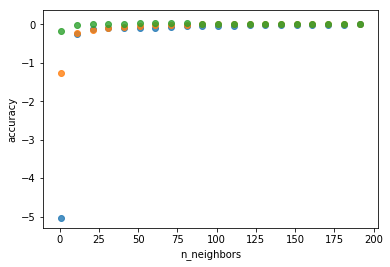

In [11]:

sp0 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split0_test_score'], fit_reg = False, label = 'split0').set(xlabel = 'n_neighbors', ylabel = 'accuracy')
sp1 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split1_test_score'], fit_reg = False, label = 'split1')
sp2 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split2_test_score'], fit_reg = False, label = 'split2')

plt.show()


In [12]:
knn_200 = neighbors.KNeighborsRegressor(n_neighbors = 200)
knn_200.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])
knn_200.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

-0.02186305681789702

In [13]:
rf = ensemble.RandomForestRegressor()
rf.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])
rf.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


-0.65796422770410024

In [14]:
#ugghhhh the huge number of one-hot columns is causing me troubles!
#maybe it's time to switch to H2O!

#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
   #     'city_Ambato', 'city_Babahoyo',
    #   'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
     #  'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
     #  'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
      # 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       #'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_city_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0303000883159


In [15]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
     #  'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
     #  'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
     #  'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
     #  'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
     #  'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
     #  'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
     #  'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
     #  'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
     #  'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
     #  'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
     #  'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
      'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_family_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

-0.000273402333265


In [16]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
    #    'type_A',
    #   'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
       'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_type_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.021286754591


In [17]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
      'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo'
       #         ,
      # 'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
     #  'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer'
               ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_holi_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0240236383915


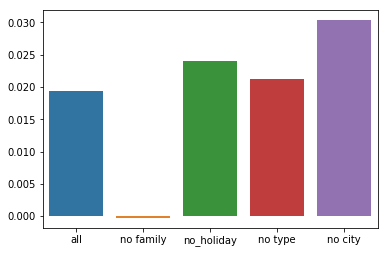

In [18]:
sns.barplot(['all', 'no family', 'no_holiday', 'no type', 'no city'], 
            [all_lin, no_family_lin, no_holi_lin, no_type_lin, no_city_lin])

In [19]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
fam_all_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0408021724041


In [20]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        #'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_oil_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0431758355535


In [21]:
v_train_cols = [
        'onpromotion', 
        #'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_perish_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0408021724039


In [22]:
v_train_cols = [
        #'onpromotion', 
        'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_promo_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0112451354041


In [23]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        'dcoilwtico',
       #'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_trans_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0445406474475


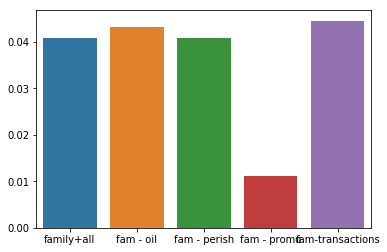

In [24]:
sns.barplot(['family+all', 'fam - oil', 'fam - perish', 'fam - promo', 'fam-transactions'], 
            [fam_all_lin, no_oil_lin, no_perish_lin, no_promo_lin, no_trans_lin])

In [25]:
v_train_cols = [
        'onpromotion', 
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
promo_trans_fam_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0431758355536


In [26]:
test = dd.read_csv('../data/raw/test.csv')
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [27]:
items = dd.read_csv('../data/raw/' + 'items.csv')
stores = dd.read_csv('../data/raw/' + 'stores.csv')
transactions = dd.read_csv('../data/raw/' + 'transactions.csv')

In [28]:
test = test.merge(items)
test = test.drop(['date','item_nbr', 'class', 'perishable'], axis = 1).compute()

test = dd.from_pandas(test, npartitions=10)

test = test.merge(stores)

test = test.drop(['city','state', 'type','cluster'], axis =1).compute()

test = dd.from_pandas(test, npartitions=10)

In [29]:
#oh hmm, we can't use transactions because it's the wrong dates!
#get the average number of transactions for each store number and assign transactions to test
#data based on store number?
new_trans_pd = transactions.groupby('store_nbr')['transactions'].mean().compute().to_frame()
new_trans_pd['store_nbr'] = new_trans_pd.index
new_trans_pd.head()

,transactions,store_nbr
store_nbr,,
1,1523.844272,1
2,1920.036374,2
3,3201.879475,3
4,1502.987470,4
5,1400.045915,5


In [30]:
new_trans = dd.from_pandas(new_trans_pd, npartitions=10)

new_trans.head()

,transactions,store_nbr
store_nbr,,
1,1523.844272,1
2,1920.036374,2
3,3201.879475,3
4,1502.987470,4
5,1400.045915,5


In [31]:
test = test.merge(new_trans)

test = test.compute()

test = test.drop_duplicates()

In [32]:
test2 = pd.concat([test, pd.get_dummies(test['family'], prefix = 'family')], axis = 1)

test2.iloc[range(11), :]

,id,store_nbr,onpromotion,family,transactions,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,125497040,1,False,GROCERY I,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,127394773,1,False,DAIRY,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,125707694,1,False,GROCERY I,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,127605427,1,False,DAIRY,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,125918348,1,False,GROCERY I,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,127816081,1,False,DAIRY,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,126129002,1,False,GROCERY I,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,128026735,1,False,DAIRY,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,126339656,1,False,GROCERY I,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,128237389,1,False,DAIRY,1523.844272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
test.to_csv('../data/test_concatted.csv')

In [34]:
out = lin_reg.predict(test2.loc[:, v_train_cols])

out[:10]

array([[ 5.26947253],
       [ 4.70118475],
       [ 5.26947253],
       [ 4.70118475],
       [ 5.26947253],
       [ 4.70118475],
       [ 5.26947253],
       [ 4.70118475],
       [ 5.26947253],
       [ 4.70118475]])

In [35]:
out_pd = pd.DataFrame(out, columns = ['unit_sales'], index = test2.id)

out_pd.head()

,unit_sales
id,
125497040,5.269473
127394773,4.701185
125707694,5.269473
127605427,4.701185
125918348,5.269473


In [36]:
no_neg = np.where(out_pd['unit_sales']>0, out_pd['unit_sales'], 0)

out_pd['unit_sales'] = no_neg

In [37]:
out_pd.to_csv('../data/first_lin_reg.csv')